In [1]:
import os, sys
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from tqdm import tqdm
import statsmodels.api as sm
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import date
pd.options.mode.chained_assignment = None
import statistics

# 数据整合
# stock market value

In [2]:
mv_path = "/Users/charlesxiong/Desktop/量化投资/FF3F_data/stock_mv/"
dirs = os.listdir(mv_path)

In [3]:
i = 0
df_list = []

for file in dirs:
    ## skip the useless file
    if file == '.DS_Store':
        i = i + 1
        continue
    #get the last-day data
    data = pd.read_csv(mv_path + str(dirs[i]))
    data.TRADE_DT = pd.to_datetime(data['TRADE_DT'], format='%Y%m%d', errors='coerce')
    #combine all files
    df_list.append(data)
    i = i + 1

#convert list to pd
mv_data = pd.concat(df_list)
mv_data = mv_data.sort_values(by="TRADE_DT")
mv_data = mv_data.drop(columns = ['Unnamed: 0'])

In [4]:
#joined dataframe in file: stock_mv
mv_data.columns = ['S_INFO_WINDCODE', 'TRADE_DT', '当日总市值', '当日流通市值', '市净率PB', '换手率']

#get the last transaction date in each month
d = pd.DataFrame(columns = ['l1', 'l2'])
k = mv_data["TRADE_DT"].reset_index()
d['l1'] = k["TRADE_DT"]
d['l2'] = k["TRADE_DT"]
end_date = d.set_index('l1').groupby([pd.Grouper(freq='M')]).max()
end_date = end_date.reset_index().l2.tolist()

#get the corresponding data
mv_data = mv_data.loc[mv_data['TRADE_DT'].isin(end_date)]
#standardize the month
mv_data = mv_data.set_index('TRADE_DT').groupby([pd.Grouper(freq='M'), 'S_INFO_WINDCODE']).mean()
mv_data = mv_data.reset_index(level=['TRADE_DT', 'S_INFO_WINDCODE'])
mv_data

,TRADE_DT,S_INFO_WINDCODE,当日总市值,当日流通市值,市净率PB,换手率
0,2000-07-31,000001.SZ,2.872469e+06,1.983595e+06,9.3307,0.7664
1,2000-07-31,000002.SZ,8.757891e+05,5.534121e+05,4.1843,1.7921
2,2000-07-31,000003.SZ,2.240674e+05,1.288590e+05,21.9062,2.0291
3,2000-07-31,000004.SZ,2.306840e+05,1.144324e+05,34.5238,2.2884
4,2000-07-31,000005.SZ,5.180175e+05,2.456295e+05,5.1151,1.5181
...,...,...,...,...,...,...
557830,2021-07-31,688788.SH,9.743161e+05,2.245189e+05,3.4607,5.3275
557831,2021-07-31,688789.SH,1.572136e+06,3.193994e+05,12.0709,12.4754
557832,2021-07-31,688799.SH,6.560372e+05,1.337854e+05,4.8517,67.0469
557833,2021-07-31,688819.SH,4.311264e+06,4.481936e+05,3.8165,3.5659


# stock_price growth

In [5]:
price_path = "/Users/charlesxiong/Desktop/量化投资/FF3F_data/adj_factors/"
dirs = os.listdir(price_path)

In [6]:
df_list = []
i = 0
for file in dirs:
    
    ## skip the useless file
    if file == '.DS_Store':
        i = i + 1
        continue
    data = pd.read_csv(price_path + str(dirs[i]))
    data.TRADE_DT = pd.to_datetime(data['TRADE_DT'], format='%Y%m%d', errors='coerce')
    #combine all data in the folder: stock_price
    df_list.append(data)
    i = i + 1

price_data = pd.concat(df_list)
price_data = price_data.sort_values(by="TRADE_DT")
price_data = price_data.drop(columns = ['Unnamed: 0'])


In [7]:
#get the last transaction date in each month
d = pd.DataFrame(columns = ['l1', 'l2'])
k = price_data["TRADE_DT"].reset_index()
d['l1'] = k["TRADE_DT"]
d['l2'] = k["TRADE_DT"]
end_date = d.set_index('l1').groupby([pd.Grouper(freq='M')]).max()
end_date = end_date.reset_index().l2.tolist()

#get the corresponding data
price_data = price_data.loc[price_data['TRADE_DT'].isin(end_date)]
price_data = price_data.sort_values(by="TRADE_DT")
# price_data.columns = [ 'S_INFO_WINDCODE', 'TRADE_DT', '复权收盘价', '复权因子']
price_data.columns = [ 'S_INFO_WINDCODE', 'TRADE_DT', '复权收盘价', '复权因子']
price_data = price_data.reset_index().drop(columns = ['index'])
                                                    
price_data

,S_INFO_WINDCODE,TRADE_DT,复权收盘价,复权因子
0,600235.SH,2000-07-31,13.84,1.000000
1,000001.SZ,2000-07-31,400.96,21.661613
2,000002.SZ,2000-07-31,124.85,8.995214
3,000003.SZ,2000-07-31,25.76,3.833487
4,000004.SZ,2000-07-31,85.47,3.111524
...,...,...,...,...
557896,002949.SZ,2021-07-19,18.43,1.045487
557897,002950.SZ,2021-07-19,23.92,1.605341
557898,002951.SZ,2021-07-19,10.31,1.053006
557899,002945.SZ,2021-07-19,12.35,1.014054


<AxesSubplot:xlabel='TRADE_DT'>

/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22797 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 26435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 25910 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 30424 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 20215 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anacon

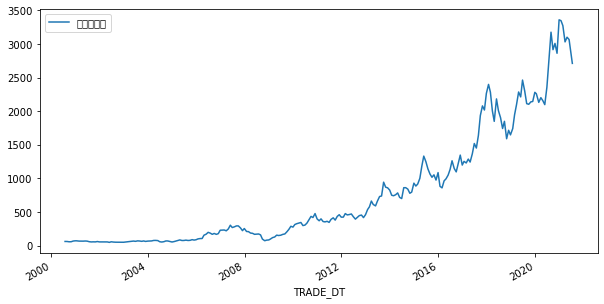

In [8]:
#收益率
price_data['涨跌幅'] = price_data.sort_values(['TRADE_DT']).groupby('S_INFO_WINDCODE')['复权收盘价'].pct_change()
price_datak = price_data[price_data['S_INFO_WINDCODE'] == '600887.SH']
price_datak.plot(x='TRADE_DT', y = '复权收盘价', figsize=(10,5))

In [9]:
#standardize the dates
price_data = price_data.set_index('TRADE_DT').groupby([pd.Grouper(freq='M'), 'S_INFO_WINDCODE']).mean()
price_data = price_data.reset_index(level=['TRADE_DT', 'S_INFO_WINDCODE'])


# Rf

In [10]:
Rf_table = pd.read_excel('/Users/charlesxiong/Desktop/量化投资/FF3F_data/risk_free_rate/中债国债到期收益率(中债)(日).xls')
Rf_table.DT = pd.to_datetime(Rf_table['DT'], format='%Y%m%d', errors='coerce')
Rf_table
Rf_table.columns = ['TRADE_DT', '无风险收益率']
Rf_data = Rf_table.set_index('TRADE_DT').groupby([pd.Grouper(freq='M')]).mean()
Rf_data = Rf_data.reset_index(level=['TRADE_DT'])
#percentage to float
Rf_data['无风险收益率'] = Rf_data['无风险收益率']/100
Rf_data

,TRADE_DT,无风险收益率
0,2002-01-31,0.021268
1,2002-02-28,0.021819
2,2002-03-31,0.019575
3,2002-04-30,0.019794
4,2002-05-31,0.018815
...,...,...
230,2021-03-31,0.026264
231,2021-04-30,0.025017
232,2021-05-31,0.023405
233,2021-06-30,0.024506


In [15]:
Rf_data = real[['TRADE_DT', 'RF']]
Rf_data.columns = ['TRADE_DT', '无风险收益率']

# Market

      S_INFO_WINDCODE   TRADE_DT  S_DQ_PRECLOSE  S_DQ_CLOSE  S_DQ_PCTCHANGE
20245      000985.CSI 2004-12-31      1000.0000   1000.0000             NaN
20265      000985.CSI 2005-01-31       962.2460    941.2990         -2.1769
20278      000985.CSI 2005-02-28      1035.3960   1030.3650         -0.4859
20301      000985.CSI 2005-03-31       916.0880    922.0960          0.6558
20322      000985.CSI 2005-04-29       904.9730    894.5180         -1.1553
...               ...        ...            ...         ...             ...
24192      000985.CSI 2021-03-31      5463.4299   5433.6977         -0.5442
24213      000985.CSI 2021-04-30      5572.6645   5544.2558         -0.5098
24231      000985.CSI 2021-05-31      5764.9983   5809.3676          0.7696
24252      000985.CSI 2021-06-30      5785.4997   5834.1879          0.8416
24262      000985.CSI 2021-07-14      5861.0727   5798.9801         -1.0594

[200 rows x 5 columns]


<AxesSubplot:xlabel='TRADE_DT'>

/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 22330 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 28072 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 36300 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 24133 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/charlesxiong/opt/anacon

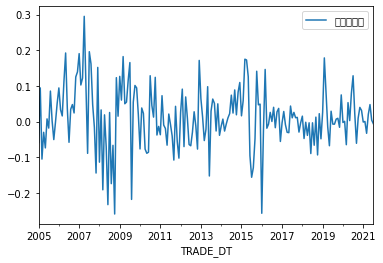

In [16]:
MKT_table = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/market_price/market_price.csv')
MKT_table.TRADE_DT = pd.to_datetime(MKT_table['TRADE_DT'], format='%Y%m%d', errors='coerce')
MKT_table = MKT_table.drop(columns = ['Unnamed: 0'])
CSI = MKT_table[MKT_table['S_INFO_WINDCODE'] == "000985.CSI"]

#get the last day of months
d = pd.DataFrame(columns = ['l1', 'l2'])
k = CSI["TRADE_DT"].reset_index()
d['l1'] = k["TRADE_DT"]
d['l2'] = k["TRADE_DT"]
end_date = d.set_index('l1').groupby([pd.Grouper(freq='M')]).max()
end_date = end_date.reset_index().l2.tolist()
CSI = CSI.loc[CSI['TRADE_DT'].isin(end_date)]
CSI = CSI.sort_values(by="TRADE_DT")
print(CSI)
#get %changes
CSI_data = pd.DataFrame(columns = ['TRADE_DT', '市场涨跌幅'])
CSI_data['TRADE_DT'] = CSI.TRADE_DT[1:]
diff = np.array(CSI.S_DQ_CLOSE.diff()[1:])
S_DQ_CLOSE = np.array(CSI.S_DQ_CLOSE[:len(CSI)-1])
CSI_data['市场涨跌幅'] = diff/S_DQ_CLOSE
CSI_data = CSI_data.set_index('TRADE_DT').groupby([pd.Grouper(freq='M')]).max()
CSI_data = CSI_data.reset_index()
CSI_data.plot(x = 'TRADE_DT', y = '市场涨跌幅')

# ROE

In [17]:
ROE_table = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/ROE.CSV')
ROE_table['ANN_DT'] = pd.to_datetime(ROE_table['ANN_DT'], format='%Y%m%d', errors='coerce')
ROE_table['REPORT_PERIOD'] = pd.to_datetime(ROE_table['REPORT_PERIOD'], format='%Y%m%d', errors='coerce')

#quarterly data
ROE_table

,Unnamed: 0,S_INFO_WINDCODE,REPORT_PERIOD,ANN_DT,S_FA_ROE
0,0,688179.SH,2014-06-30,2014-08-07,12.7206
1,1,688057.SH,2014-06-30,2014-08-07,20.3544
2,2,600832.SH,2014-06-30,2014-08-08,7.8592
3,3,603187.SH,2014-06-30,2014-08-08,31.0189
4,4,301041.SZ,2014-06-30,2014-08-07,3.8088
...,...,...,...,...,...
235989,235989,002982.SZ,2012-12-31,2015-11-13,18.9140
235990,235990,A17195.SZ,2014-06-30,2014-08-06,21.2986
235991,235991,A15192.SZ,2013-12-31,2015-07-03,9.8559
235992,235992,A14686.SH,2013-12-31,2016-05-06,21.4788


In [18]:
# k = ROE_table[ROE_table['S_INFO_WINDCODE'] == '000004.SZ']
# k = k.sort_values('ANN_DT')
# k = k.loc[(k.ANN_DT - k.REPORT_PERIOD).astype('timedelta64[D]')<100]
# k['TRADE_DT'] = k.ANN_DT + pd.offsets.MonthEnd(2) #当月中公布的数据不能在当月底使用，而是在下个月底使用
# L = pd.merge(result, k, on = ['S_INFO_WINDCODE', 'TRADE_DT'], how = 'left')
# L.fillna(method='ffill', inplace=True)

# L[L['S_INFO_WINDCODE'] == '000004.SZ'].iloc[100:150]

# SMB HML momentum

In [19]:
result = pd.merge(mv_data, price_data, on=['TRADE_DT', 'S_INFO_WINDCODE'], how='inner')
result['BM'] = 1/result['市净率PB']  #define book-to-market value
result = result.drop(columns = ['换手率', '当日流通市值', '复权因子','市净率PB']).dropna(axis = 0)
r_result = result.pivot(index='TRADE_DT', columns='S_INFO_WINDCODE', values='当日总市值')
r_result = r_result.reset_index()
r_result = r_result[r_result['TRADE_DT'].dt.month==4]
r_result = r_result.set_index('TRADE_DT')
r_result = r_result.stack().reset_index()
r_result.columns = ['TRADE_DT', 'S_INFO_WINDCODE', '当日总市值']
r_result = pd.merge(r_result, result, how = 'inner')

label_data = pd.DataFrame()

#create labels for market value and BM
for date in r_result.TRADE_DT.unique():
    stock_group = r_result[r_result['TRADE_DT'] == date]
    #label mv
    mv_med = stock_group.当日总市值.median()
    stock_group['mv_label'] = np.select([stock_group['当日总市值']<mv_med,stock_group['当日总市值']>mv_med],['Small','Big']).tolist()
    #label BM
    BM_30, BM_70 = stock_group.BM.quantile([.3, .7])
    stock_group['BM_label'] = np.select([stock_group['BM']<BM_30,stock_group['BM']>BM_70],['Low','High'], 'Medium').tolist()
    
    stock_group['year'] = stock_group['TRADE_DT'].dt.year
    
    label_data = pd.concat([label_data, stock_group], axis = 0)

In [96]:
label_data

,S_INFO_WINDCODE,当日总市值,BM,mv_label,BM_label,year
0,000001.SZ,3.021862e+06,0.156821,Big,Medium,2001
1,000002.SZ,9.199571e+05,0.315906,Big,High,2001
2,000004.SZ,2.424407e+05,0.036686,Small,Low,2001
3,000005.SZ,5.148270e+05,0.160169,Big,Medium,2001
4,000006.SZ,3.633968e+05,0.308985,Big,High,2001
...,...,...,...,...,...,...
46202,688699.SH,9.871608e+05,0.116641,Big,Low,2021
46203,688777.SH,4.288649e+06,0.094097,Big,Low,2021
46204,688788.SH,7.591190e+05,0.378831,Big,Medium,2021
46205,688819.SH,4.092541e+06,0.290276,Big,Medium,2021


In [20]:
result = result.drop(columns = ['当日总市值','BM'])
label_data = label_data.drop(columns = ['TRADE_DT','复权收盘价','涨跌幅'])

#add labels to result data
result['year'] = result['TRADE_DT'].dt.year
result.loc[result["TRADE_DT"].dt.month <= 4, "year"] -= 1  #新年5月前用到的数据仍为去年数据
result = pd.merge(result, label_data, on = ['S_INFO_WINDCODE', 'year'], how = 'inner')

#add ROE to result data
ROE = ROE_table.loc[(ROE_table.ANN_DT - ROE_table.REPORT_PERIOD).astype('timedelta64[D]')<180] #排除修改以前数据的情况
ROE['TRADE_DT'] = ROE.ANN_DT + pd.offsets.MonthEnd(2) #当月中公布的数据不能在当月底使用，而是在下个月底使用
#如果两个季度数据在同一时期公布，则选用最新季度的数据
ROE = ROE.sort_values(by="REPORT_PERIOD").groupby(['S_INFO_WINDCODE'], as_index=False).apply(lambda group: group.drop_duplicates(subset='TRADE_DT', keep='last', inplace=False))
result = pd.merge(result, ROE, on = ['S_INFO_WINDCODE', 'TRADE_DT'], how = 'left')
result = result.sort_values(by="TRADE_DT").groupby(['S_INFO_WINDCODE'], as_index=False).apply(lambda group: group.ffill())


#剔除新股
new = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/股票上市日期.csv', encoding = "ISO-8859-1")
new = new.drop(columns = ['S_INFO_NAME', 'Unnamed: 0'])
new.S_INFO_LISTDATE = pd.to_datetime(new['S_INFO_LISTDATE'], format='%Y%m%d', errors='coerce') + pd.offsets.MonthEnd(0)
new.S_INFO_DELISTDATE = pd.to_datetime(new['S_INFO_DELISTDATE'], format='%Y%m%d', errors='coerce') + pd.offsets.MonthEnd(0)
result = pd.merge(result, new, on=['S_INFO_WINDCODE'], how='inner')
result.S_INFO_DELISTDATE = pd.to_datetime(result['S_INFO_DELISTDATE'], format='%Y%m%d', errors='coerce')
result['diff_date'] = (result.TRADE_DT - result.S_INFO_LISTDATE).astype('timedelta64[D]')
result = result[result['diff_date'] > 365]

#剔除即将退市
result['diff_end'] = (result.S_INFO_DELISTDATE - result.TRADE_DT).astype('timedelta64[D]')
result = result[(result['diff_end'] > 180) | (result['diff_end'].isna())]

#去除极值
def rm_outliers(df):
    data = pd.DataFrame()
    
    for date in df.TRADE_DT.unique():
        stocks = df[df['TRADE_DT'] == date]
        mean = stocks.涨跌幅.mean()
        std = stocks.涨跌幅.std()
        no_outlier = stocks[(stocks['涨跌幅']>=(mean-3*std)) & (stocks['涨跌幅']<=(mean+3*std))]
        data = pd.concat([data, no_outlier], axis = 0)

    return data

result = rm_outliers(result)

result

,TRADE_DT,S_INFO_WINDCODE,复权收盘价,涨跌幅,year,当日总市值,BM,mv_label,BM_label,Unnamed: 0,REPORT_PERIOD,ANN_DT,S_FA_ROE,S_INFO_LISTDATE,S_INFO_DELISTDATE,diff_date,diff_end
0,2001-05-31,000001.SZ,394.62,0.043140,2001,3.021862e+06,0.156821,Big,Medium,20761.0,2000-12-31,2001-04-14,13.2610,1991-04-30,NaT,3684.0,NaN
243,2001-05-31,600228.SH,21.32,0.015238,2001,3.780000e+05,0.119204,Big,Low,21445.0,2000-12-31,2001-03-31,3.5057,1999-01-31,NaT,851.0,NaN
461,2001-05-31,000691.SZ,24.19,0.097052,2001,2.796089e+05,0.225372,Small,High,21031.0,2000-12-31,2001-04-11,0.4154,1997-02-28,NaT,1553.0,NaN
704,2001-05-31,600756.SH,64.41,0.026618,2001,4.229652e+05,0.055841,Big,Low,NaN,NaT,NaT,NaN,1996-09-30,NaT,1704.0,NaN
947,2001-05-31,600227.SH,15.59,0.097887,2001,2.414000e+05,0.290225,Small,High,NaN,NaT,NaT,NaN,2000-02-29,NaT,457.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514908,2021-07-31,603353.SH,38.24,0.012980,2021,6.108804e+05,0.273905,Big,Medium,226969.0,2021-03-31,2021-04-27,1.9959,2020-04-30,NaT,457.0,NaN
514914,2021-07-31,603087.SH,118.58,-0.209677,2021,7.563944e+06,0.120681,Big,Low,231627.0,2021-03-31,2021-04-30,2.1042,2020-06-30,NaT,396.0,NaN
514917,2021-07-31,603095.SH,23.39,-0.001281,2021,2.984520e+05,0.668226,Small,High,227246.0,2021-03-31,2021-04-27,2.6299,2020-04-30,NaT,457.0,NaN
514920,2021-07-31,603439.SH,14.14,-0.071569,2021,6.545668e+05,0.153589,Big,Low,228705.0,2021-03-31,2021-04-28,2.3592,2020-04-30,NaT,457.0,NaN


In [21]:
df_index = pd.DataFrame(columns = ['TRADE_DT', 'SMB', 'HML'])
df_W_index = pd.DataFrame(columns = ['TRADE_DT', 'W_SMB', 'W_HML','ROE_HML'])
mm_index = pd.DataFrame(columns = ['TRADE_DT', 'mm_HML'])
fx_index = pd.DataFrame(columns = ['TRADE_DT', 'fx_HML'])


for date in result.TRADE_DT.unique():
    
    
    ####################   HML SMB   ###########################
    #All stocks on a specific month
    stock_group = result[result['TRADE_DT'] == date]

    group_SL = stock_group[(stock_group['mv_label']=='Small') & (stock_group['BM_label']=='Low')]
    group_SM = stock_group[(stock_group['mv_label']=='Small') & (stock_group['BM_label']=='Medium')]
    group_SH = stock_group[(stock_group['mv_label']=='Small') & (stock_group['BM_label']=='High')]
    group_BL = stock_group[(stock_group['mv_label']=='Big') & (stock_group['BM_label']=='Low')]
    group_BM = stock_group[(stock_group['mv_label']=='Big') & (stock_group['BM_label']=='Medium')]
    group_BH = stock_group[(stock_group['mv_label']=='Big') & (stock_group['BM_label']=='High')]
    
#     ###compute SMB, HML by date (未加权平均)
#     W_SMB = 1/3 * (group_SL.涨跌幅.mean() + group_SM.涨跌幅.mean() + group_SH.涨跌幅.mean()) - 1/3 * (group_BL.涨跌幅.mean() + group_BM.涨跌幅.mean() + group_BH.涨跌幅.mean())
#     W_HML = 1/2 * (group_SH.涨跌幅.mean() + group_BH.涨跌幅.mean()) - 1/2 * (group_SL.涨跌幅.mean() + group_BL.涨跌幅.mean())

    ##加权平均
    SL_weights = group_SL.当日总市值/group_SL.当日总市值.sum()
    SM_weights = group_SM.当日总市值/group_SM.当日总市值.sum()
    SH_weights = group_SH.当日总市值/group_SH.当日总市值.sum()
    BL_weights = group_BL.当日总市值/group_BL.当日总市值.sum()
    BM_weights = group_BM.当日总市值/group_BM.当日总市值.sum()
    BH_weights = group_BH.当日总市值/group_BH.当日总市值.sum()
    
    W_SMB = (1/3) * (group_SL.涨跌幅@SL_weights + group_SM.涨跌幅@SM_weights + group_SH.涨跌幅@SH_weights) - (1/3) * (group_BL.涨跌幅@BL_weights + group_BM.涨跌幅@BM_weights + group_BH.涨跌幅@BH_weights)
    W_HML = (1/2) * (group_SH.涨跌幅@SH_weights + group_BH.涨跌幅@BH_weights) - (1/2) * (group_SL.涨跌幅@SL_weights + group_BL.涨跌幅@BL_weights)
    
    ################### ROE ##########################
    #set percentile and grouping
    ROE_10, ROE_90 = stock_group.S_FA_ROE.quantile([.3, .7])
    L_ROE = stock_group[stock_group['S_FA_ROE'] <= ROE_10]
    H_ROE = stock_group[stock_group['S_FA_ROE'] >= ROE_90]
    
    #set weights
    LR_weights = L_ROE.当日总市值/L_ROE.当日总市值.sum()
    HR_weights = H_ROE.当日总市值/H_ROE.当日总市值.sum()
    
    #因子
    ROE_HML = H_ROE.涨跌幅@HR_weights - L_ROE.涨跌幅@LR_weights
    
    W_index = [date, W_SMB, W_HML,ROE_HML]
    df_W_index.loc[len(df_W_index), :] = W_index

df_W_index.TRADE_DT = df_W_index.TRADE_DT.astype('datetime64[ns]')

In [22]:
df_W_index

,TRADE_DT,W_SMB,W_HML,ROE_HML
0,2001-05-31,0.0430751,-0.021156,-0.0519108
1,2001-06-30,0.0083068,0.0210799,0.0235415
2,2001-07-31,-0.00200919,-0.00653113,-0.00871128
3,2001-08-31,0.0146917,-0.0125621,-0.02735
4,2001-09-30,-0.0317899,0.005236,0.03534
...,...,...,...,...
238,2021-03-31,0.0450324,0.050264,-0.0292356
239,2021-04-30,0.00128408,-0.0260186,0.00806904
240,2021-05-31,0.0121012,-0.0188688,-0.0141858
241,2021-06-30,0.0325423,-0.0348286,-0.00997474


In [23]:
    ####################### 动量因子计算（频率为季度） ####################
#计算过去12个月（剔除最近一个月）收益率
mm_HML_list = []
fx_HML_list = []
date_ls = []


p_result = result.pivot(index='TRADE_DT', columns='S_INFO_WINDCODE', values='复权收盘价')
roll_12m = p_result.pct_change(periods=9) #11个月的累计收益率
roll_12m = roll_12m.shift(periods=3) #当月对应过去11个月的累计收益率,相当于过去12个月剔除最近一个月
growth_12m = roll_12m.stack().reset_index()
growth_12m.columns = ['TRADE_DT', 'S_INFO_WINDCODE', '动量']

roll_1m = p_result.pct_change(periods=2) #11个月的累计收益率
roll_1m = roll_1m.shift(periods=1) #当月对应过去11个月的累计收益率,相当于过去12个月剔除最近一个月
growth_1m = roll_1m.stack().reset_index()
growth_1m.columns = ['TRADE_DT', 'S_INFO_WINDCODE', '反向']

In [24]:
#将动量加入result数据
result = pd.merge(result, growth_12m, how='inner', on = ['TRADE_DT', 'S_INFO_WINDCODE'])
result = pd.merge(result, growth_1m, how='inner', on = ['TRADE_DT', 'S_INFO_WINDCODE'])

#分类计算动量
for date in result.TRADE_DT.unique():
    mm_stock = result[result['TRADE_DT'] == date]
    
    mmQ30, mmQ70 = mm_stock['动量'].quantile([.3, .7])
    L_mm = mm_stock[mm_stock['动量'] < mmQ30]
    H_mm = mm_stock[mm_stock['动量'] > mmQ70]
    
    #mm_HML
    mm_HML = H_mm.涨跌幅.mean() - L_mm.涨跌幅.mean()
    mm_HML_list.append(mm_HML)
    
    ##反向
    
    fxQ30, fxQ70 = mm_stock['反向'].quantile([.3, .7])
    L_fx = mm_stock[mm_stock['反向'] < fxQ30]
    H_fx = mm_stock[mm_stock['反向'] > fxQ70]
    
    #mm_HML
    fx_HML = H_fx.涨跌幅.mean() - L_fx.涨跌幅.mean()
    fx_HML_list.append(fx_HML)
    date_ls.append(date)
    

mm_index['mm_HML'] = mm_HML_list
mm_index['TRADE_DT'] = date_ls
fx_index['fx_HML'] = fx_HML_list
fx_index['TRADE_DT'] = date_ls

In [25]:
df_W_index = pd.merge(df_W_index, mm_index, on = ['TRADE_DT'], how = 'inner')
df_W_index = pd.merge(df_W_index, fx_index, on = ['TRADE_DT'], how = 'inner')
df_W_index

,TRADE_DT,W_SMB,W_HML,ROE_HML,mm_HML,fx_HML
0,2002-05-31,0.000446823,-0.00700221,-0.0101013,-0.002914,0.005740
1,2002-06-30,-0.0279235,0.0606382,0.0215064,-0.004989,-0.041803
2,2002-07-31,0.0016029,-0.0191983,0.00725367,0.012724,-0.025384
3,2002-08-31,0.00322329,0.000239465,0.0125205,0.000094,-0.003088
4,2002-09-30,-0.00976369,-0.00839151,0.0177167,0.015404,0.021186
...,...,...,...,...,...,...
226,2021-03-31,0.0450324,0.050264,-0.0292356,-0.026994,-0.008555
227,2021-04-30,0.00128408,-0.0260186,0.00806904,0.038243,-0.030545
228,2021-05-31,0.0121012,-0.0188688,-0.0141858,-0.002907,0.003886
229,2021-06-30,0.0325423,-0.0348286,-0.00997474,-0.001201,0.000144


# Fama-French modeling

In [67]:
# merge all the data
df1 = df_W_index.set_index('TRADE_DT').join(result.set_index('TRADE_DT'))
df1 = df1.reset_index()
df2 = df1.set_index('TRADE_DT').join(Rf_data.set_index('TRADE_DT'))
df2 = df2.reset_index()
df3 = df2.set_index('TRADE_DT').join(CSI_data.set_index('TRADE_DT'))
df3 = df3.reset_index()

#final data for modeling
final = df3[df3['TRADE_DT'] >= '2005-01-31']

#Risk-market - Risk-free
final['MKT_minus_free'] = final.市场涨跌幅 - final.无风险收益率
#涨跌幅-Rf
final['grow_minus_free'] = final.涨跌幅 - final.无风险收益率

In [68]:
final = final[final['TRADE_DT'] <= '2021-06-30']
final[['TRADE_DT', 'S_INFO_WINDCODE', 'W_SMB', 'W_HML', 'ROE_HML', 'mm_HML', 'fx_HML', '涨跌幅', 'MKT_minus_free', 'grow_minus_free']]

,TRADE_DT,S_INFO_WINDCODE,W_SMB,W_HML,ROE_HML,mm_HML,fx_HML,涨跌幅,MKT_minus_free,grow_minus_free
33113,2005-01-31,000001.SZ,-0.0104718,0.00854091,0.00883802,0.001827,-0.005978,-0.080437,-0.060068,-0.081804
33114,2005-01-31,600228.SH,-0.0104718,0.00854091,0.00883802,0.001827,-0.005978,0.012365,-0.060068,0.010998
33115,2005-01-31,000691.SZ,-0.0104718,0.00854091,0.00883802,0.001827,-0.005978,-0.072626,-0.060068,-0.073993
33116,2005-01-31,600756.SH,-0.0104718,0.00854091,0.00883802,0.001827,-0.005978,-0.150981,-0.060068,-0.152348
33117,2005-01-31,600227.SH,-0.0104718,0.00854091,0.00883802,0.001827,-0.005978,-0.077792,-0.060068,-0.079159
...,...,...,...,...,...,...,...,...,...,...
441584,2021-06-30,603267.SH,0.0325423,-0.0348286,-0.00997474,-0.001201,0.000144,-0.006146,0.002862,-0.007556
441585,2021-06-30,603068.SH,0.0325423,-0.0348286,-0.00997474,-0.001201,0.000144,0.146375,0.002862,0.144965
441586,2021-06-30,601698.SH,0.0325423,-0.0348286,-0.00997474,-0.001201,0.000144,-0.014572,0.002862,-0.015982
441587,2021-06-30,603327.SH,0.0325423,-0.0348286,-0.00997474,-0.001201,0.000144,0.015635,0.002862,0.014225


In [89]:
#时间序列回归: get betas for each stock
MKT_coef = []
SMB_coef = []
HML_coef = []
stocks = []
Pvalue = []
su = pd.DataFrame(columns = ['sum'])
P_rate = pd.DataFrame(columns = ['TRADE_DT', 'portfolio_rate'])
beta_coefs = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'MKT_coef', 'SMB_coef', 'HML_coef'])

#找到2005至2021一直存在的股票
# data2005 = final[final['TRADE_DT'] == '2005-1-31']
# data2015 = final[final['TRADE_DT'] == '2021-07-31']
# both = pd.merge(data2005, data2015, on=['S_INFO_WINDCODE'], how = 'inner').S_INFO_WINDCODE.unique()

#计算某支股票投资组合的整体月度收益率
def get_ff_info(stock_list, pvalue, rsquare):
    su = 0
    count = 0
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        count = count + 1
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'mm_HML', 'fx_HML', 'ROE_HML']].values.astype(float))
        
        if pvalue == True:
#             print('\n', stock,'\n', (model_ts.fit().pvalues<0.05).sum())
            p = (model_ts.fit().pvalues<0.05).sum()
            
        elif rsquare == True:
            print('\n', stock,'\n', model_ts.fit().rsquared)
        else:
            print('\n', stock, model_ts.fit().summary())
        su = p + su
    return su/count

#计算不同时间区间R2变化
final['year'] = final['TRADE_DT'].dt.year


def get_ff_time(stock_list, begin, end):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Year', 'Rsqr', 'p_x1', 'p_x2', 'p_x3', 'p_x4','p_x5'])
    time = final[(final['TRADE_DT']>=begin) & (final['TRADE_DT']<=end)]
    for stock in stock_list:
        stock_data = time[time['S_INFO_WINDCODE'] == stock]
        for year in stock_data['year'].unique():
            year_data = stock_data[stock_data['year'] == year]
            model_ts = sm.OLS(year_data['grow_minus_free'].astype(float), 
                year_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'mm_HML', 'fx_HML']].values.astype(float))
            rsqr_df.loc[len(rsqr_df),:] = [stock, year, model_ts.fit().rsquared_adj, model_ts.fit().pvalues[0], model_ts.fit().pvalues[1], model_ts.fit().pvalues[2], model_ts.fit().pvalues[3], model_ts.fit().pvalues[4]]
    
    return rsqr_df


def get_c2(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        stock_data['noise1'] = np.random.normal(0.004, 0.049, [len(stock_data)]).tolist()
        stock_data['noise2'] = np.random.normal(0.002, 0.0375, [len(stock_data)]).tolist()
        stock_data['noise3'] = np.random.normal(0.009, 0.077, [len(stock_data)]).tolist()
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['noise1', 'noise2', 'noise3']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_c1(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'W_SMB', 'W_HML']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_b2(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        stock_data['noise1'] = np.random.normal(-0.001, 0.035, [len(stock_data)]).tolist()
        stock_data['noise2'] = np.random.normal(-0.01, 0.0375, [len(stock_data)]).tolist()
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'noise1', 'noise2']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_b1(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    count = 0
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'mm_HML', 'fx_HML']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_a2(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        stock_data['noise1'] = np.random.normal(0.003, 0.056, [len(stock_data)]).tolist()
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'mm_HML', 'fx_HML', 'noise1']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_a1(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    count = 0
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        count = count + 1
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'mm_HML', 'fx_HML', 'ROE_HML']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df, count

def get_a0(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    count = 0
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        count = count + 1
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['mm_HML', 'fx_HML', 'ROE_HML']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df, count
################################################################################################
    
#横截面回归
#计算每支股票的betas
# for stock in tqdm(both):
#     ind_var = final[final['S_INFO_WINDCODE'] == stock]

#     model = sm.OLS(ind_var['grow_minus_free'].astype(float), sm.add_constant(
#         ind_var[['MKT_minus_free', 'W_SMB', 'W_HML']].values.astype(float)))
#     results = model.fit().params[1:]
    
#     #append coef to lists
#     MKT_coef.append(results[0])
#     SMB_coef.append(results[1])
#     HML_coef.append(results[2])
#     stocks.append(stock)
    
    
#     #计算constant p-value
#     pvalue = model.fit().pvalues[0]
#     Pvalue.append(pvalue)
#     break
    
    

# beta_coefs['MKT_coef'] = MKT_coef
# beta_coefs['SMB_coef'] = SMB_coef
# beta_coefs['HML_coef'] = HML_coef
# beta_coefs['S_INFO_WINDCODE'] = stocks

# beta_coefs
    

In [90]:
#行业分类
classification = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/中信行业分类.csv', encoding = 'gb2312')
classification = classification[classification['levelnum'] == 2.0]
top_30 = classification.Industriesname.unique().tolist()
classification = classification[classification['Industriesname'].isin(top_30)]



# c2

In [63]:
#行业分类
classification = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/中信行业分类.csv', encoding = 'gb2312')
classification = classification[classification['levelnum'] == 2.0]
top_30 = classification.Industriesname.unique().tolist()
classification = classification[classification['Industriesname'].isin(top_30)]

nan_df = pd.DataFrame(columns = ['Names','nan-R-Squared'])
#行业股票代码
for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    nan = get_c2(k)
    nan_df.loc[len(nan_df), :] = [top_30[i], nan['Rsqr'].mean()]

# c1

In [71]:
ff_df = pd.DataFrame(columns = ['Names','ff-R-Squared'])
#行业股票代码
for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    ff = get_c1(k)
    ff_df.loc[len(ff_df), :] = [top_30[i], ff['Rsqr'].mean()]

# b2

In [72]:
noise_df = pd.DataFrame(columns = ['Names','noise-R-Squared'])

for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    noise = get_b2(k)
    noise_df.loc[len(noise_df), :] = [top_30[i], noise['Rsqr'].mean()]

# b1

In [73]:
full_df = pd.DataFrame(columns = ['Names','full-R-Squared'])

for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    full = get_b1(k)
    full_df.loc[len(full_df), :] = [top_30[i], full['Rsqr'].mean()]

# a2

In [85]:
a2_df = pd.DataFrame(columns = ['Names','ROE-R-Squared'])

for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    a2 = get_a2(k)
    a2_df.loc[len(a2_df), :] = [top_30[i], a2['Rsqr'].mean()]

# a1

In [76]:
ROE_df = pd.DataFrame(columns = ['Names','ROE-R-Squared', 'Count'])

for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    ROE, count = get_a1(k)
    ROE_df.loc[len(ROE_df), :] = [top_30[i], ROE['Rsqr'].mean(), count]

In [87]:
compare = pd.merge(nan_df, ff_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, noise_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, full_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, a2_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, ROE_df, how = 'inner', on = ['Names'])

compare

,Names,nan-R-Squared,ff-R-Squared,noise-R-Squared,full-R-Squared,ROE-R-Squared_x,ROE-R-Squared_y,Count
0,银行,0.00341531,0.616881,0.618857,0.618229,0.616187,0.63182,25
1,房地产,8.12532e-05,0.493569,0.493588,0.499828,0.499619,0.502594,126
2,医药,-0.00247681,0.414457,0.410256,0.430462,0.430817,0.431193,278
3,电力及公用事业,-0.000516826,0.467308,0.468239,0.473284,0.472533,0.475409,141
4,机械,-0.000979962,0.424491,0.428082,0.431852,0.43047,0.434352,289
5,综合,0.00138122,0.498732,0.499656,0.504398,0.504807,0.50791,60
6,建筑,0.00359094,0.410569,0.414503,0.421792,0.42272,0.423809,117
7,建材,-0.00706925,0.432829,0.435623,0.434981,0.436012,0.436538,75
8,家电,0.00536844,0.393247,0.391291,0.400501,0.404002,0.411883,66
9,农林牧渔,0.00144403,0.406445,0.402244,0.421041,0.423319,0.422261,82


In [93]:
roe_df = pd.DataFrame(columns = ['Names','ROE-R-Squared', 'Count'])

for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    ROE, count = get_a0(k)
    roe_df.loc[len(roe_df), :] = [top_30[i], ROE['Rsqr'].mean(), count]

In [94]:
roe_df

,Names,ROE-R-Squared,Count
0,银行,0.0955806,25
1,房地产,0.160919,126
2,医药,0.2058,278
3,电力及公用事业,0.184053,141
4,机械,0.186874,289
5,综合,0.234442,60
6,建筑,0.18295,117
7,建材,0.182722,75
8,家电,0.154101,66
9,农林牧渔,0.193325,82


In [36]:
for i in range(len(top_30)):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    l = get_ff_info(k, pvalue = True, rsquare = False)
    print(l)

2.72
2.0238095238095237
1.8776978417266188
2.0
1.8373702422145328
2.1166666666666667
1.794871794871795
1.7866666666666666
1.9242424242424243
2.0121951219512195
1.7927461139896372
1.9903846153846154
1.9219858156028369
2.1
2.125
2.066326530612245
1.802919708029197
2.048780487804878
1.8725490196078431
1.9345794392523366
2.037037037037037
2.018099547511312
1.881918819188192
1.510204081632653
2.4615384615384617
1.8688524590163935
2.1666666666666665
2.066666666666667
1.7840909090909092
2.026315789473684


In [95]:
roe_df.to_clipboard()

In [38]:
compare.Count.sum()

3400

In [39]:
# k = stock_data[['grow_minus_free', 'W_SMB', 'W_HML', 'MKT_minus_free']]
# k = k.astype(float)
# k.corr()

In [40]:
#横截面回归 fama macbeth
# r_sqr = pd.DataFrame(columns = ['date', 'rsquared'])
# pvalue = pd.DataFrame(columns = ['date', 'const_pv','MKT_pv', 'SMB_pv', 'HML_pv'])

# #merge
# for date in final['TRADE_DT'].unique():

#     data20150430 = final[final['TRADE_DT'] == date]
#     cross_section = pd.merge(data20150430, beta_coefs, on = ['S_INFO_WINDCODE'], how = 'inner')

#     #model
#     model = sm.OLS(cross_section['grow_minus_free'].astype(float), sm.add_constant(cross_section[['MKT_coef', 'SMB_coef', 'HML_coef']].values.astype(float)))
    
    
#     results = model.fit()
    
#     results.params[1:]
    #r_sqr.loc[len(r_sqr),:] = [date, results.rsquared]
    #pvalue.loc[len(pvalue),:] = [date, results.pvalues[0], results.pvalues[1], results.pvalues[2], results.pvalues[3]]

In [41]:
#r_sqr.plot(x = 'date', y = 'rsquared')  # R-square

In [42]:
#final
#result.to_excel("/Users/charlesxiong/Desktop/量化投资/FF3F_data/result_data.xlsx", index=False)

# 真实值

In [99]:
real = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/Carhart-四因子模型（经典算法）月收益率（截至到20210630）.csv')
real = real[(real['date'] > '2004-12-31')]
real.columns = ['TRADE_DT', 'RF', 'MKT', 'SMB', 'HML', 'UMD']
real['cumu_SMB'] = real.SMB.cumsum()
real['cumu_HML'] = real.HML.cumsum()
real['cumu_UMD'] = real.UMD.cumsum()
# real.TRADE_DT = real.TRADE_DT.astype('datetime64[ns]')
# k = pd.merge(final, real, on = ['TRADE_DT'], how = 'inner')
# k = k[k['S_INFO_WINDCODE'] == '000895.SZ']


# model_ts = sm.OLS(k['grow_minus_free'].astype(float), sm.add_constant(
#             k[['MKT_minus_free', 'SMB', 'HML', 'mm_HML']].values.astype(float)))
# model_ts.fit().summary()

<AxesSubplot:xlabel='TRADE_DT'>

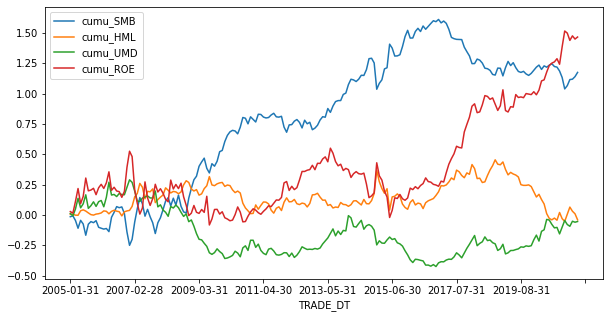

In [100]:
real_ROE = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/Hou-Xue-Zhang-四因子模型（极简算法）月收益率（截至到20210731）.csv')
real_ROE = real_ROE[['date','R_roe']]
real_ROE.columns = ['TRADE_DT', 'ROE']
real = pd.merge(real, real_ROE, on = ['TRADE_DT'])
real['cumu_ROE'] = real.ROE.cumsum()
real.plot(x='TRADE_DT', y=['cumu_SMB', 'cumu_HML', 'cumu_UMD', 'cumu_ROE'], figsize=(10,5))

(-0.55, 1.75)

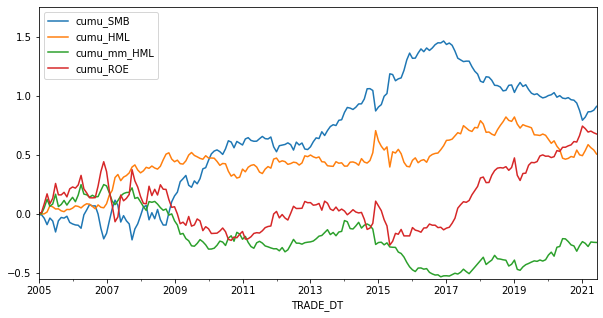

In [101]:
#我计算的值
mine = df_W_index[(df_W_index['TRADE_DT'] > '2004-12-31') & (df_W_index['TRADE_DT'] < '2021-7-31')]
mine['cumu_SMB'] = mine.W_SMB.cumsum()
mine['cumu_HML'] = mine.W_HML.cumsum()
mine['cumu_mm_HML'] = mine.mm_HML.cumsum()
mine['cumu_fx'] = mine.fx_HML.cumsum()
mine['cumu_ROE'] = mine.ROE_HML.cumsum()
k = mine.plot(x='TRADE_DT', y=['cumu_SMB', 'cumu_HML', 'cumu_mm_HML', 'cumu_ROE'],figsize=(10,5))
k.set_ylim(-0.55, 1.75)

In [98]:
mine[mine['TRADE_DT'] > '2008-01-31'].head(50)

,TRADE_DT,W_SMB,W_HML,ROE_HML,mm_HML,fx_HML,cumu_SMB,cumu_HML,cumu_mm_HML,cumu_fx,cumu_ROE
69,2008-02-29,0.073916,0.017008,-0.058107,-0.040080,0.005977,0.0580566,0.36424,0.061975,-0.719800,0.0891784
70,2008-03-31,0.012775,0.029882,-0.003839,-0.032160,0.024256,0.0708316,0.394122,0.029816,-0.695544,0.0853398
71,2008-04-30,-0.120851,-0.008372,0.148865,0.074344,-0.059793,-0.0500193,0.385749,0.104159,-0.755337,0.234205
72,2008-05-31,0.060193,0.019325,-0.079048,-0.005968,-0.034309,0.0101742,0.405074,0.098192,-0.789646,0.155157
73,2008-06-30,-0.051074,-0.016671,0.052966,0.007414,0.037115,-0.0408995,0.388403,0.105606,-0.752532,0.208123
74,2008-07-31,0.078240,-0.009344,-0.048200,-0.022566,-0.069286,0.0373401,0.379059,0.083040,-0.821817,0.159923
75,2008-08-31,-0.086799,0.024128,0.086741,-0.029772,0.033343,-0.0494592,0.403186,0.053267,-0.788475,0.246665
76,2008-09-30,-0.044698,0.054558,-0.037834,-0.022556,-0.018778,-0.0941573,0.457745,0.030711,-0.807253,0.208831
77,2008-10-31,-0.000180,0.047806,-0.001492,0.010724,0.026886,-0.0943372,0.505551,0.041435,-0.780366,0.207339
78,2008-11-30,0.104364,0.011513,-0.086288,-0.051685,-0.064934,0.0100263,0.517064,-0.010250,-0.845300,0.121051


In [59]:
mine.ROE_HML.mean()

0.003416396170486719

# corr: real vs mine

In [47]:
real[['SMB', 'HML']] = real[['SMB', 'HML']].astype(np.float64) 
real

,TRADE_DT,RF,MKT,SMB,HML,UMD,cumu_SMB,cumu_HML,cumu_UMD,ROE,cumu_ROE
0,2005-01-31,0.001367,-0.060420,-0.014422,0.004899,0.012161,-0.014422,0.004899,0.012161,0.027621,0.027621
1,2005-02-28,0.000836,0.097467,0.006918,0.000787,-0.019389,-0.007504,0.005686,-0.007229,-0.012734,0.014887
2,2005-03-31,0.001103,-0.095033,-0.037929,-0.007409,0.056525,-0.045433,-0.001723,0.049296,0.096780,0.111666
3,2005-04-30,0.000662,-0.023377,-0.064167,-0.000986,0.088254,-0.109600,-0.002709,0.137550,0.106259,0.217925
4,2005-05-31,0.000552,-0.082067,0.065173,0.037140,-0.078569,-0.044427,0.034431,0.058981,-0.124343,0.093582
...,...,...,...,...,...,...,...,...,...,...,...
193,2021-02-28,0.001155,0.003554,0.027073,0.058391,-0.033384,1.066165,0.005291,-0.078878,-0.017361,1.499179
194,2021-03-31,0.001712,-0.023959,0.050069,0.059502,-0.014511,1.116234,0.064793,-0.093389,-0.060105,1.439074
195,2021-04-30,0.001500,0.011932,0.002947,-0.034122,0.041555,1.119182,0.030671,-0.051834,0.037439,1.476513
196,2021-05-31,0.001239,0.048950,0.021158,-0.021017,-0.008056,1.140340,0.009654,-0.059890,-0.026428,1.450085


In [48]:
mine[['W_SMB', 'W_HML', 'ROE_HML']] = mine[['W_SMB', 'W_HML', 'ROE_HML']].astype(np.float64) 

In [49]:
np.corrcoef(np.array(real.SMB),np.array(mine.W_SMB))

array([[1.        , 0.97687262],
       [0.97687262, 1.        ]])

In [50]:
np.corrcoef(np.array(real.HML), np.array(mine.W_HML)) #HML

array([[1.        , 0.89040965],
       [0.89040965, 1.        ]])

In [51]:
np.corrcoef(np.array(real.UMD), np.array(mine.mm_HML))

array([[1.        , 0.95252356],
       [0.95252356, 1.        ]])

In [52]:
np.corrcoef(np.array(real.ROE), np.array(mine.ROE_HML))

array([[1.        , 0.88222527],
       [0.88222527, 1.        ]])

1.文章中使用年度数据进行SMB HML的计算，而我使用的是月度数据。所以文章中所分的六组股票只有每年才变化一次，但是我的计算中是每月变化一次。2.我的模型是2005年至2021年7月所有一直存在的股票，并非整个A股市场的所有股票。

# 因子的corr

In [53]:
mine[['W_SMB','W_HML','mm_HML','fx_HML']].corr()

,W_SMB,W_HML,mm_HML,fx_HML
W_SMB,1.000000,-0.321846,-0.354851,-0.258008
W_HML,-0.321846,1.000000,-0.314707,0.018093
mm_HML,-0.354851,-0.314707,1.000000,0.263287
fx_HML,-0.258008,0.018093,0.263287,1.000000


# 模型对比：经典算法

In [54]:
real

,TRADE_DT,RF,MKT,SMB,HML,UMD,cumu_SMB,cumu_HML,cumu_UMD,ROE,cumu_ROE
0,2005-01-31,0.001367,-0.060420,-0.014422,0.004899,0.012161,-0.014422,0.004899,0.012161,0.027621,0.027621
1,2005-02-28,0.000836,0.097467,0.006918,0.000787,-0.019389,-0.007504,0.005686,-0.007229,-0.012734,0.014887
2,2005-03-31,0.001103,-0.095033,-0.037929,-0.007409,0.056525,-0.045433,-0.001723,0.049296,0.096780,0.111666
3,2005-04-30,0.000662,-0.023377,-0.064167,-0.000986,0.088254,-0.109600,-0.002709,0.137550,0.106259,0.217925
4,2005-05-31,0.000552,-0.082067,0.065173,0.037140,-0.078569,-0.044427,0.034431,0.058981,-0.124343,0.093582
...,...,...,...,...,...,...,...,...,...,...,...
193,2021-02-28,0.001155,0.003554,0.027073,0.058391,-0.033384,1.066165,0.005291,-0.078878,-0.017361,1.499179
194,2021-03-31,0.001712,-0.023959,0.050069,0.059502,-0.014511,1.116234,0.064793,-0.093389,-0.060105,1.439074
195,2021-04-30,0.001500,0.011932,0.002947,-0.034122,0.041555,1.119182,0.030671,-0.051834,0.037439,1.476513
196,2021-05-31,0.001239,0.048950,0.021158,-0.021017,-0.008056,1.140340,0.009654,-0.059890,-0.026428,1.450085


In [55]:
# merge all the data
df1 = real.set_index('TRADE_DT').join(result.set_index('TRADE_DT'))
df1 = df1.reset_index()
df2 = df1.set_index('TRADE_DT').join(Rf_data.set_index('TRADE_DT'))
df2 = df2.reset_index()
df3 = df2.set_index('TRADE_DT').join(CSI_data.set_index('TRADE_DT'))
df3 = df3.reset_index()

#final data for modeling
final = df3[df3['TRADE_DT'] >= '2005-01-31']

#Risk-market - Risk-free
final['MKT_minus_free'] = final.MKT - final.RF
#涨跌幅-Rf
final['grow_minus_free'] = final.涨跌幅 - final.RF
final = final[final['TRADE_DT'] <= '2021-06-30']

#时间序列回归: get betas for each stock
MKT_coef = []
SMB_coef = []
HML_coef = []
stocks = []
Pvalue = []
P_rate = pd.DataFrame(columns = ['TRADE_DT', 'portfolio_rate'])
beta_coefs = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'MKT_coef', 'SMB_coef', 'HML_coef'])

#找到2005至2021一直存在的股票
# data2005 = final[final['TRADE_DT'] == '2005-1-31']
# data2015 = final[final['TRADE_DT'] == '2021-07-31']
# both = pd.merge(data2005, data2015, on=['S_INFO_WINDCODE'], how = 'inner').S_INFO_WINDCODE.unique()

#计算某支股票投资组合的整体月度收益率
def get_ff_info(stock_list, pvalue, rsquare):
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'SMB', 'HML', 'UMD']].values.astype(float))
        
        if pvalue == True:
            print('\n', stock,'\n', model_ts.fit().pvalues)
        elif rsquare == True:
            print('\n', stock,'\n', model_ts.fit().rsquared)
        else:
            print('\n', stock, model_ts.fit().summary())
            
  
#计算不同时间区间R2变化
final['year'] = final['TRADE_DT'].dt.year


def get_ff_time(stock_list, begin, end):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Year', 'Rsqr', 'p_x1', 'p_x2', 'p_x3', 'p_x4','p_x5'])
    time = final[(final['TRADE_DT']>=begin) & (final['TRADE_DT']<=end)]
    for stock in stock_list:
        stock_data = time[time['S_INFO_WINDCODE'] == stock]
        for year in stock_data['year'].unique():
            year_data = stock_data[stock_data['year'] == year]
            model_ts = sm.OLS(year_data['grow_minus_free'].astype(float), 
                year_data[['MKT_minus_free', 'W_SMB', 'W_HML', 'mm_HML', 'fx_HML']].values.astype(float))
            rsqr_df.loc[len(rsqr_df),:] = [stock, year, model_ts.fit().rsquared_adj, model_ts.fit().pvalues[0], model_ts.fit().pvalues[1], model_ts.fit().pvalues[2], model_ts.fit().pvalues[3], model_ts.fit().pvalues[4]]
    
    return rsqr_df


def get_average_nan(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        stock_data['noise1'] = np.random.normal(0.004, 0.049, [len(stock_data)]).tolist()
        stock_data['noise2'] = np.random.normal(0.002, 0.0375, [len(stock_data)]).tolist()
        stock_data['noise3'] = np.random.normal(0.009, 0.077, [len(stock_data)]).tolist()
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['noise1', 'noise2', 'noise3']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_average_ff(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'SMB', 'HML']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_average_noise(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        stock_data['noise1'] = np.random.normal(-0.001, 0.035, [len(stock_data)]).tolist()
        stock_data['noise2'] = np.random.normal(-0.01, 0.0375, [len(stock_data)]).tolist()
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'SMB', 'HML', 'noise1']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_average_full(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    count = 0
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'SMB', 'HML', 'UMD']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df


def get_average_ROE(stock_list):
    rsqr_df = pd.DataFrame(columns = ['S_INFO_WINDCODE', 'Rsqr'])
    count = 0
    for stock in stock_list:
        stock_data = final[final['S_INFO_WINDCODE'] == stock]
        if len(stock_data) <= 20:
            continue
        count = count + 1
        model_ts = sm.OLS(stock_data['grow_minus_free'].astype(float), 
            stock_data[['MKT_minus_free', 'SMB', 'HML', 'UMD','ROE']].values.astype(float))
        rsqr_df.loc[len(rsqr_df),:] = [stock, model_ts.fit().rsquared_adj]
    return rsqr_df, count
################################################################################################

#行业分类
classification = pd.read_csv('/Users/charlesxiong/Desktop/量化投资/FF3F_data/中信行业分类.csv', encoding = 'gb2312')
classification = classification[classification['levelnum'] == 2.0]
top_30 = classification.Industriesname.unique().tolist()
classification = classification[classification['Industriesname'].isin(top_30)]

nan_df = pd.DataFrame(columns = ['Names','nan-R-Squared'])
#行业股票代码
for i in tqdm(range(len(top_30))):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    nan = get_average_nan(k)
    nan_df.loc[len(nan_df), :] = [top_30[i], nan['Rsqr'].mean()]


ff_df = pd.DataFrame(columns = ['Names','ff-R-Squared'])
#行业股票代码
for i in tqdm(range(len(top_30))):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    ff = get_average_ff(k)
    ff_df.loc[len(ff_df), :] = [top_30[i], ff['Rsqr'].mean()]
    
    
noise_df = pd.DataFrame(columns = ['Names','noise-R-Squared'])
for i in tqdm(range(len(top_30))):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    noise = get_average_noise(k)
    noise_df.loc[len(noise_df), :] = [top_30[i], noise['Rsqr'].mean()]

full_df = pd.DataFrame(columns = ['Names','full-R-Squared'])
for i in tqdm(range(len(top_30))):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    full = get_average_full(k)
    full_df.loc[len(full_df), :] = [top_30[i], full['Rsqr'].mean()]

ROE_df = pd.DataFrame(columns = ['Names','ROE-R-Squared', 'Count'])
for i in tqdm(range(len(top_30))):
    k = classification[classification['Industriesname'] == top_30[i]].s_info_windcode.tolist()
    ROE, count = get_average_ROE(k)
    ROE_df.loc[len(ROE_df), :] = [top_30[i], ROE['Rsqr'].mean(), count]

compare = pd.merge(nan_df, ff_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, noise_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, full_df, how = 'inner', on = ['Names'])
compare = pd.merge(compare, ROE_df, how = 'inner', on = ['Names'])
compare

100%|██████████| 30/30 [01:39<00:00,  3.31s/it]


,Names,nan-R-Squared,ff-R-Squared,noise-R-Squared,full-R-Squared,ROE-R-Squared,Count
0,银行,-0.0143711,0.631549,0.63048,0.636302,0.649214,25
1,房地产,0.000454429,0.489664,0.489135,0.495856,0.498696,126
2,医药,0.000225573,0.408252,0.410371,0.4157,0.419239,278
3,电力及公用事业,0.00147451,0.469422,0.468891,0.475223,0.479473,141
4,机械,-0.00387746,0.423373,0.423724,0.426917,0.431552,289
5,综合,0.0027626,0.49842,0.49781,0.501479,0.50391,60
6,建筑,-0.00241833,0.407049,0.406815,0.413341,0.416884,117
7,建材,-3.70526e-05,0.432356,0.433723,0.436579,0.438301,75
8,家电,0.00859751,0.39113,0.389272,0.392542,0.394931,66
9,农林牧渔,-0.00210925,0.40463,0.405437,0.409096,0.411356,82


In [56]:
compare.to_clipboard()